In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import argparse
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('style.mcstyle')

from sklearn.linear_model import LinearRegression
from scipy.odr import ODR, Model, Data


In [2]:

# ~~~ parse arguments ~~~
data = 'dC100'
fold = 2

dname = f'APR24{data}'
vcut = 1e3
Rcut = 1.5
weight = True

In [ ]:
# ~~~ load data ~~~
datapath = join('data/processed', dname)
print('Loading from:', datapath)
x = np.load(join(datapath, 'x_batch.npy'), allow_pickle=True)
theta = np.load(join(datapath, 'theta_batch.npy'), allow_pickle=True)
folds = np.load(join(datapath, 'folds_batch.npy'), allow_pickle=True)
ids = np.load(join(datapath, 'ids_batch.npy'), allow_pickle=True)
metas = np.load(join(datapath, 'metas_batch.npy'), allow_pickle=True)

sigv = metas[:, -2]
lspec = metas[:, -1]

Loading from: data/processed/APR24dC100


## Old fit (using summaries)

In [ ]:
# split
x_train = x[folds != fold]
x_test = x[folds == fold]
theta_train = theta[folds != fold]
theta_test = theta[folds == fold]
ids_train = ids[folds != fold]
ids_test = ids[folds == fold]

In [4]:

def linear_model(B, x):
    return B[0] * x + B[1]


# ~~~ apply cuts ~~~
print(f'Applying cuts: |vlos| < {vcut} km/s, Rproj < {Rcut} Mpc/h.')


def cut(x):
    x = x[np.abs(x[:, 2]) < vcut]
    Rproj = np.sqrt(x[:, 0]**2 + x[:, 1]**2)
    x = x[Rproj < Rcut]
    return x


x_train = [cut(x) for x in x_train]
x_test = [cut(x) for x in x_test]

# ~~~ remove <2 galaxies ~~~
print('Removing samples with <3 galaxies.')
mask = [len(x) > 2 for x in x_train]
x_train = [x for x, m in zip(x_train, mask) if m]
theta_train = [x for x, m in zip(theta_train, mask) if m]
ids_train = [x for x, m in zip(ids_train, mask) if m]

mask = [len(x) > 2 for x in x_test]
x_test = [x for x, m in zip(x_test, mask) if m]
theta_test = [x for x, m in zip(theta_test, mask) if m]
ids_test = [x for x, m in zip(ids_test, mask) if m]

Applying cuts: |vlos| < 1000.0 km/s, Rproj < 1.5 Mpc/h.
Removing samples with <3 galaxies.


In [ ]:


# ~~~ M-sig ~~~
print('Fitting M-sig.')


def summ(x, weights=None):
    if weights is None:
        # gapper
        return np.sqrt(np.sum((x-np.mean(x))**2)/(len(x)-1))
    # weighted by PAMICO
    mu = np.sum(x*weights)/np.sum(weights)
    sig2 = np.sum(weights*(x-mu)**2)/np.sum(weights)
    return np.sqrt(sig2)


def apply(data):
    if weight:
        output = [summ(x[:, 2], x[:, 3]) for x in data]
    else:
        output = [summ(x[:, 2]) for x in data]
    return np.log10(output).reshape(-1, 1)


feat_train, feat_test = map(apply, [x_train, x_test])
data = Data(x=np.array(feat_train).T, y=np.array(theta_train).T)
model = Model(linear_model)
beta0 = [0.0, 12.0]
odr = ODR(data, model, beta0=beta0)
output = odr.run()
output.pprint()
coef, intercept = output.beta

print('Coef:', coef, 'Intercept:', intercept)

pred = linear_model([coef, intercept], np.array(feat_test).T)
# (feat_test - intercept)/coef
std = np.std(theta_test - pred)
print('std:', std)

Fitting M-sig.
Beta: [3.99597315 4.06143051]
Beta Std Error: [0.65939609 1.61079186]
Beta Covariance: [[  6.21371291 -15.17037445]
 [-15.17037445  37.07979262]]
Residual Variance: 0.06997478236433448
Inverse Condition #: 0.0066764637814200585
Reason(s) for Halting:
  Sum of squares convergence
Coef: 3.99597314535207 Intercept: 4.061430511029797
std: 1.0932924347370072


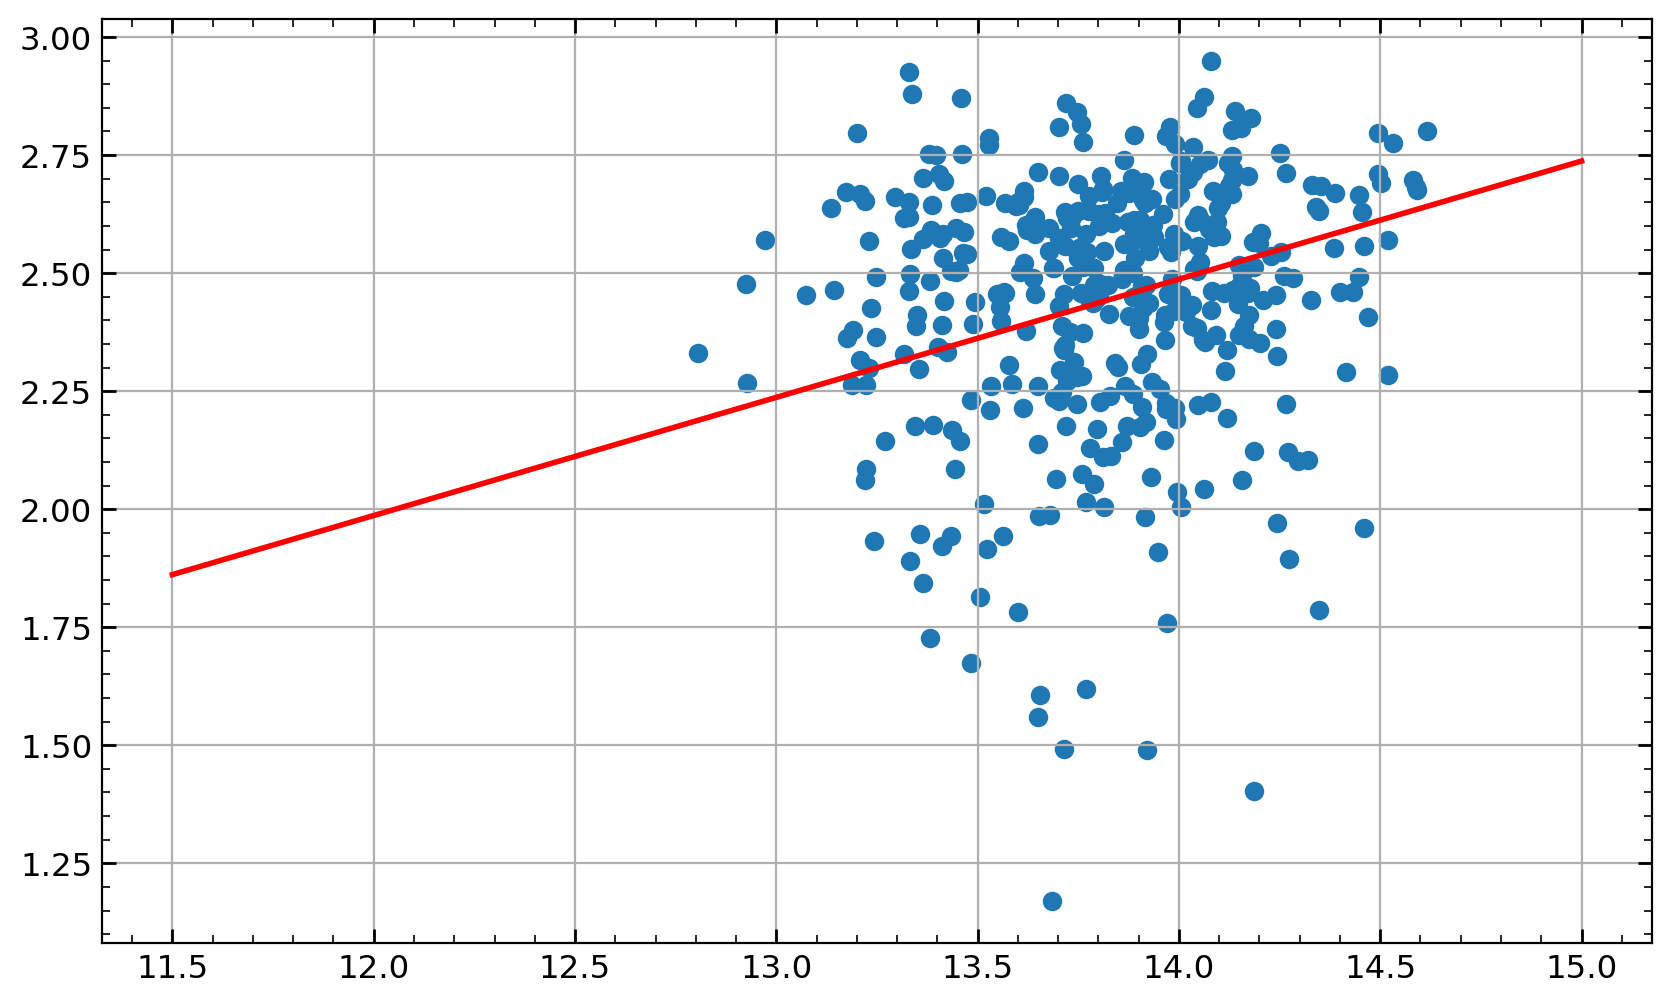

In [76]:
f, ax = plt.subplots()
ax.scatter(theta_train, feat_train, label='Train')
x_ = np.linspace(11.5, 15, 100)
ax.plot(x_, (x_ - intercept)/coef, label='Fit', c='r')

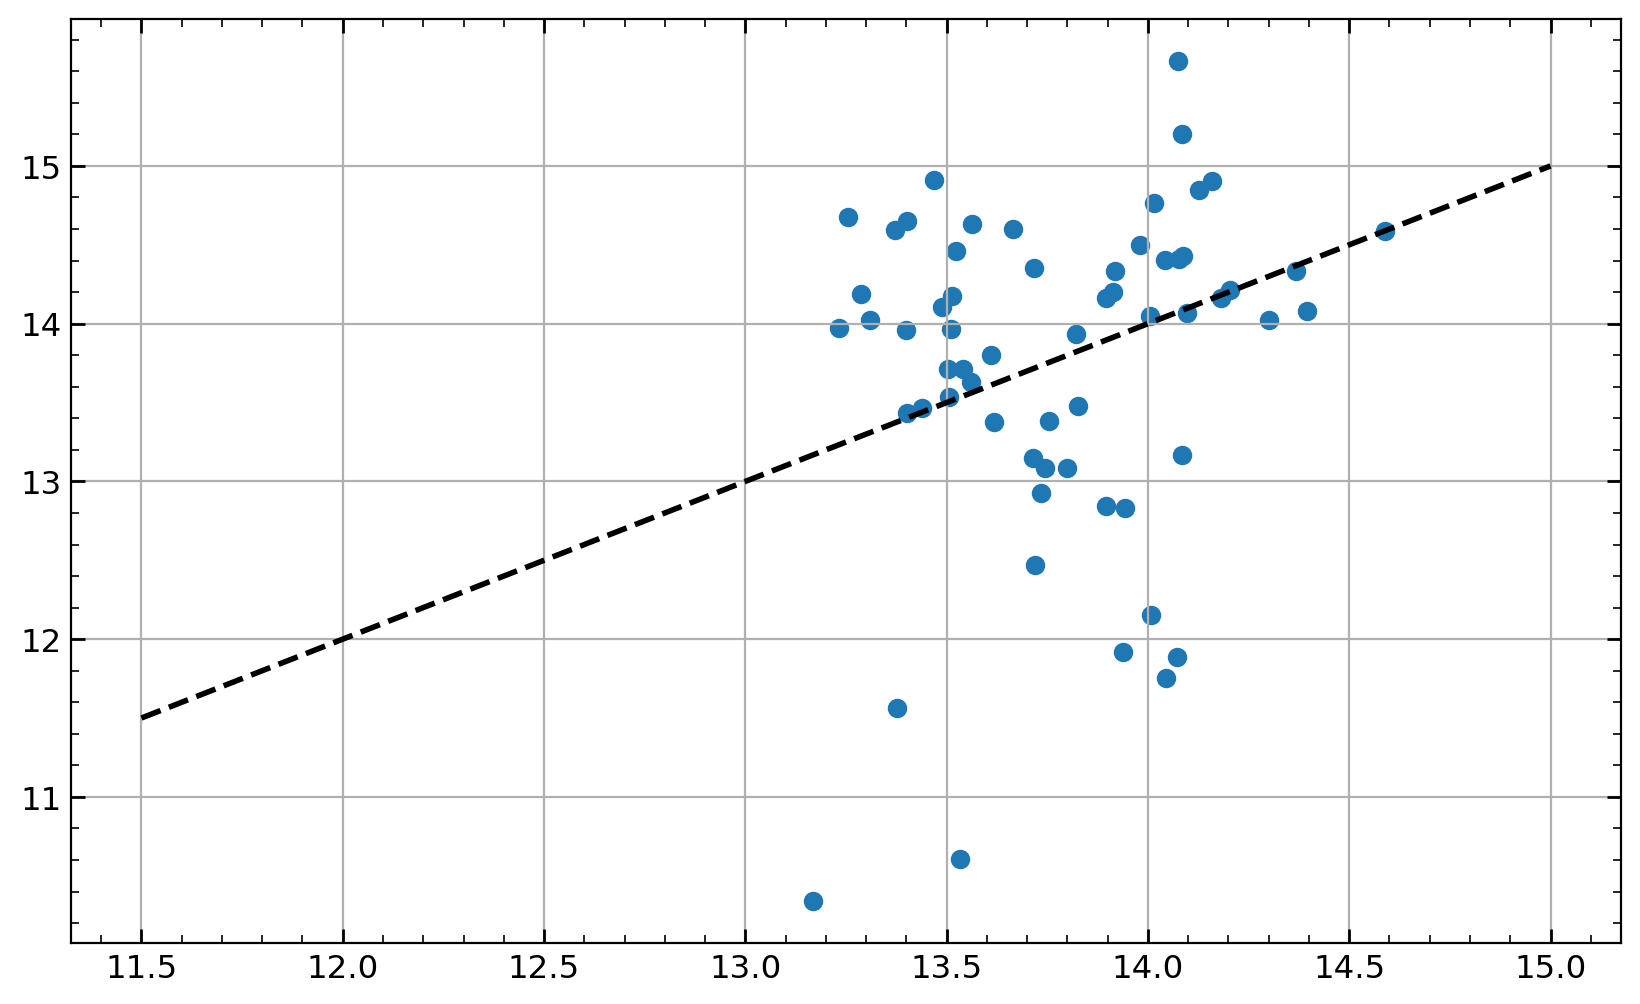

In [77]:
plt.plot(x_, x_, c='k', ls='--')
plt.scatter(theta_test, pred)

In [78]:

# ~~~ PAMICO ~~~
print('Fitting PAMICO.')


def summ(x):
    return np.sum(x)


feat_train = np.log10([summ(x[:, 3]) for x in x_train]).reshape(-1, 1)
feat_test = np.log10([summ(x[:, 3]) for x in x_test]).reshape(-1, 1)

# if args.data[0] == 'w':
#     fit_min = np.log10(1)
# elif args.data[0] == 'd':
#     fit_min = np.log10(10)
# mask = feat_train[:, 0] > fit_min

# Run ODR
data = Data(x=np.array(feat_train).T, y=np.array(theta_train).T)
model = Model(linear_model)
beta0 = [1.0, 12.0]
odr = ODR(data, model, beta0=beta0)
output = odr.run()
coef, intercept = output.beta
output.pprint()

# Predict
pred = linear_model([coef, intercept], np.array(feat_test))
std = np.std(theta_test - pred)
print('std:', std)

Fitting PAMICO.
Beta: [ 4.24986315 12.6942187 ]
Beta Std Error: [0.67919755 0.18713932]
Beta Covariance: [[ 7.82182557 -2.06708863]
 [-2.06708863  0.59380792]]
Residual Variance: 0.05897719268555486
Inverse Condition #: 0.00639650725454172
Reason(s) for Halting:
  Sum of squares convergence
std: 1.1683916489627504


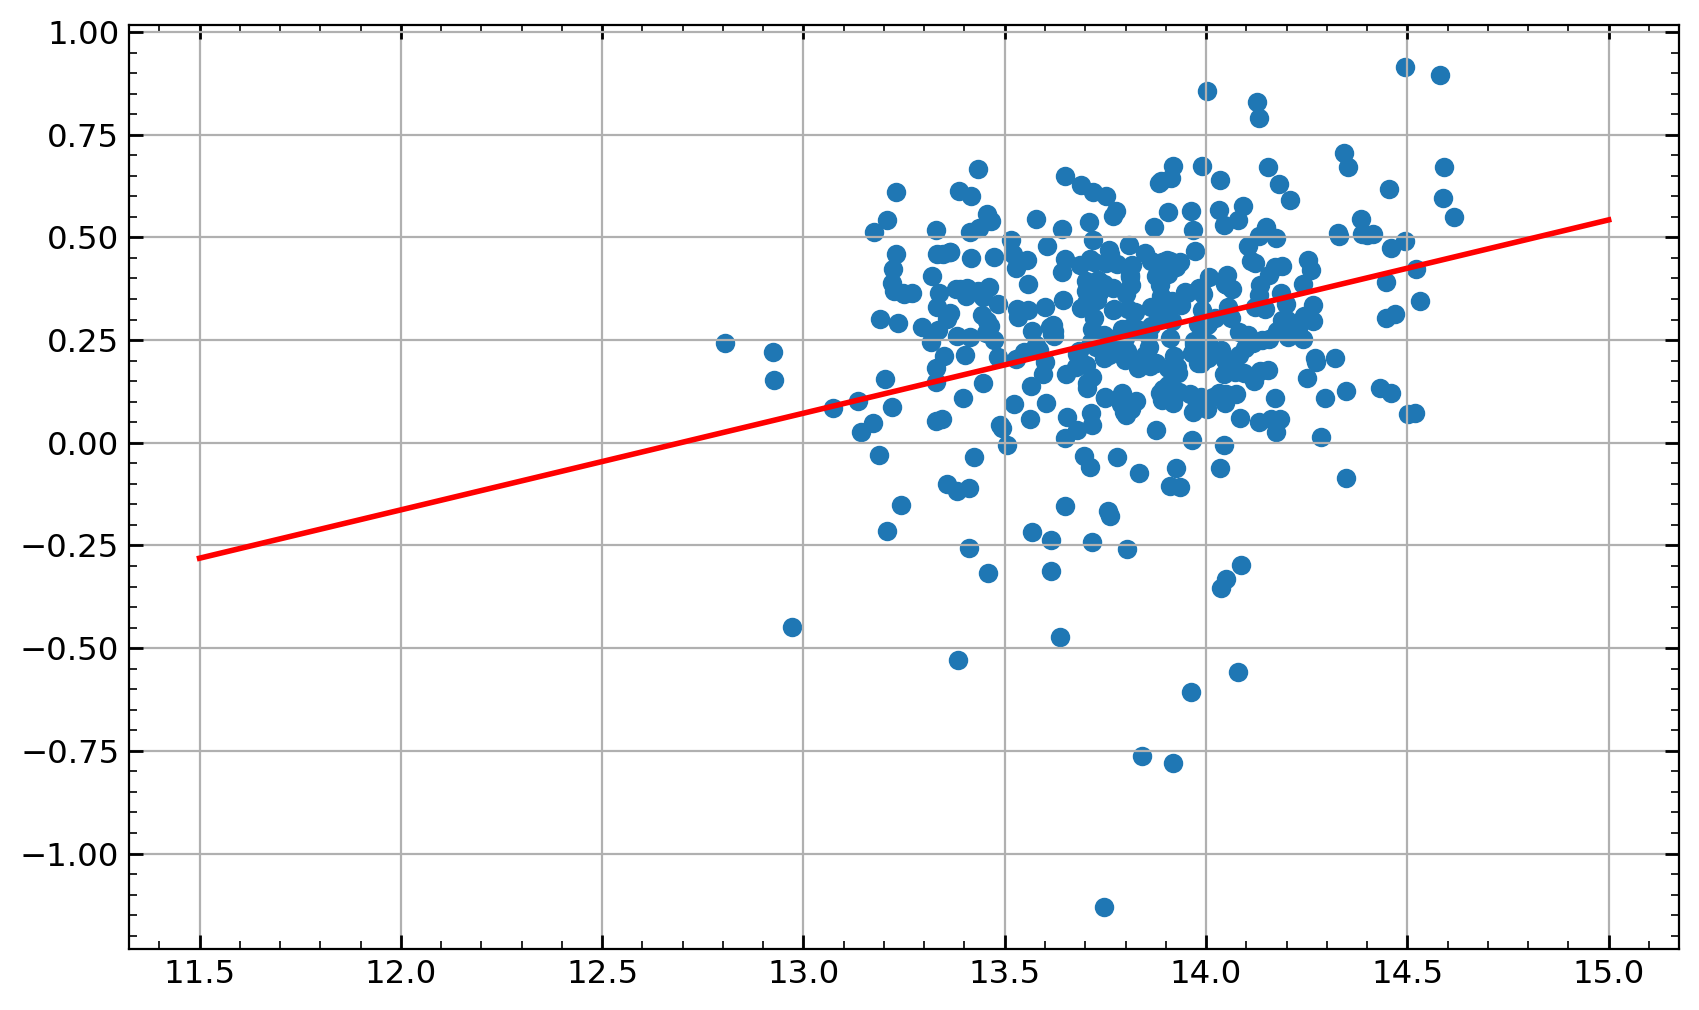

In [79]:
f, ax = plt.subplots()
ax.scatter(theta_train, feat_train, label='Train')
x_ = np.linspace(11.5, 15, 100)
ax.plot(x_, (x_-intercept)/coef, label='Fit', c='r')

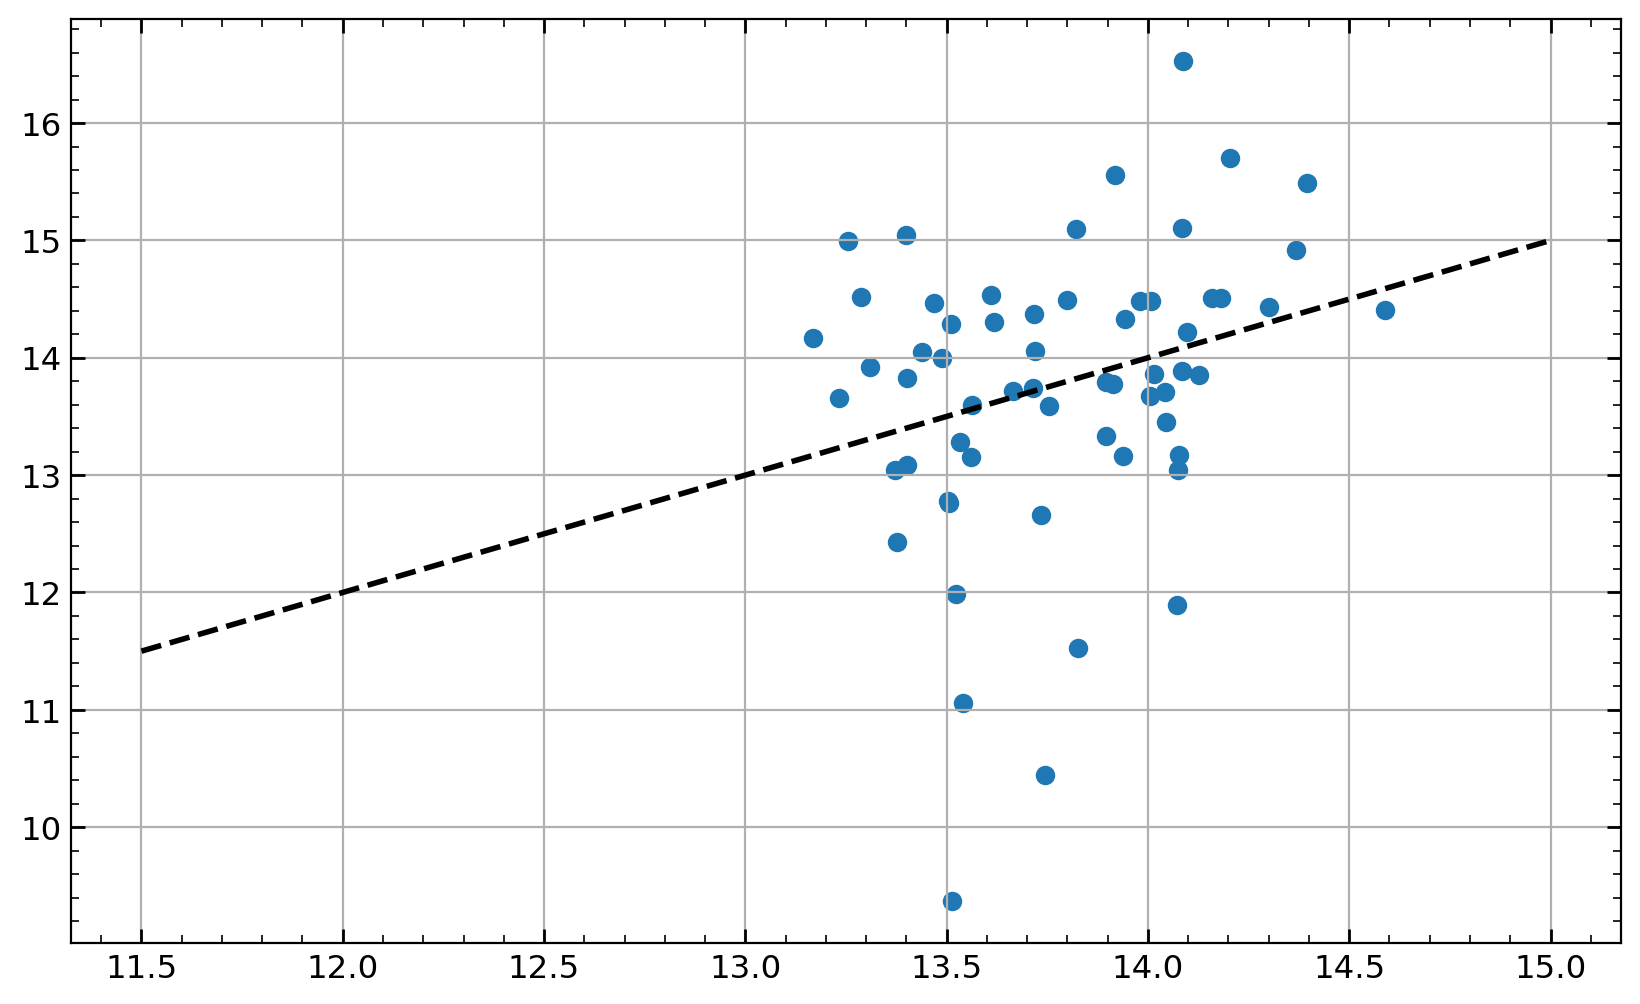

In [80]:
plt.plot(x_, x_, c='k', ls='--')
plt.scatter(theta_test, pred, label='Test')

In [72]:
np.std(pred - theta_test)

1.1683916489627504

## New fit (using meta information)

In [14]:
# ~~~ filter ~~~
min_richness = 3
mask = (lspec >= 3)

folds = folds[mask]
x = x[mask]
theta = theta[mask]
ids = ids[mask]
metas = metas[mask]
sigv = sigv[mask]
lspec = lspec[mask]

In [15]:
x_train = x[folds != fold]
x_test = x[folds == fold]
theta_train = theta[folds != fold]
theta_test = theta[folds == fold]
ids_train = ids[folds != fold]
ids_test = ids[folds == fold]
sigv_train = sigv[folds != fold]
sigv_test = sigv[folds == fold]
lspec_train = lspec[folds != fold]
lspec_test = lspec[folds == fold]

In [16]:
x.shape

(2012,)

### M-sig

In [30]:
feat_train, feat_test = map(np.log10, [sigv_train, sigv_test])
lr = LinearRegression().fit(feat_train.reshape(-1, 1), theta_train)
coef, intercept = lr.coef_[0], lr.intercept_
print('Coef:', coef, 'Intercept:', intercept)

pred = lr.predict(feat_test.reshape(-1, 1))
std = np.std(theta_test - pred)
print('std:', std)

Coef: [-0.20070811] Intercept: [14.35070976]
std: 0.33863289424252824


[Text(0.5, 0, '$\\log_{10}(\\sigma_{\\rm los})$'),
 Text(0, 0.5, '$\\log_{10}(M_{\\rm 200c})$')]

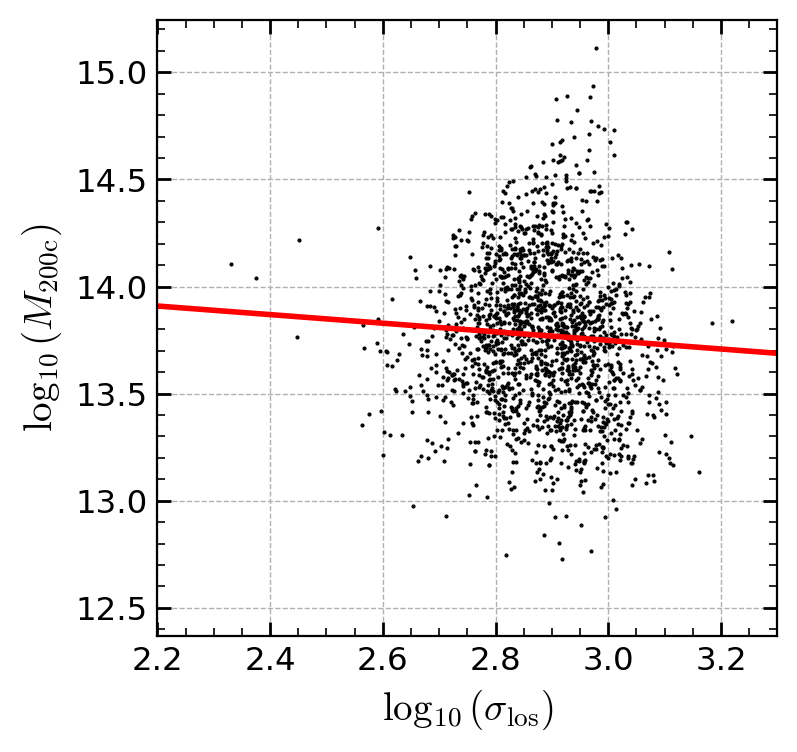

In [ ]:
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(feat_train, theta_train, '.k', label='Train', ms=1)
x_ = np.linspace(12.5, 14.5, 100)
ax.plot((x_-intercept)/coef, x_, label='Fit', c='r')
# ax.set_xlim(12.5, 15)
ax.set_xlim(2.2, 3.3)
ax.set(xlabel=r'$\log_{10}(\sigma_{\rm los})$',
       ylabel=r'$\log_{10}(M_{\rm 200c})$')

### Lambda spectroscopic

In [35]:
feat_train, feat_test = map(np.log10, [lspec_train, lspec_test])
lr = LinearRegression().fit(feat_train.reshape(-1, 1), theta_train)
coef, intercept = lr.coef_[0], lr.intercept_
print('Coef:', coef, 'Intercept:', intercept)

pred = lr.predict(feat_test.reshape(-1, 1))
std = np.std(theta_test - pred)
print('std:', std)

Coef: [0.68767079] Intercept: [12.57216179]
std: 0.33402984264462143


[Text(0.5, 0, '$\\log_{10}(\\lambda_{\\rm spec})$'),
 Text(0, 0.5, '$\\log_{10}(M_{\\rm 200c})$')]

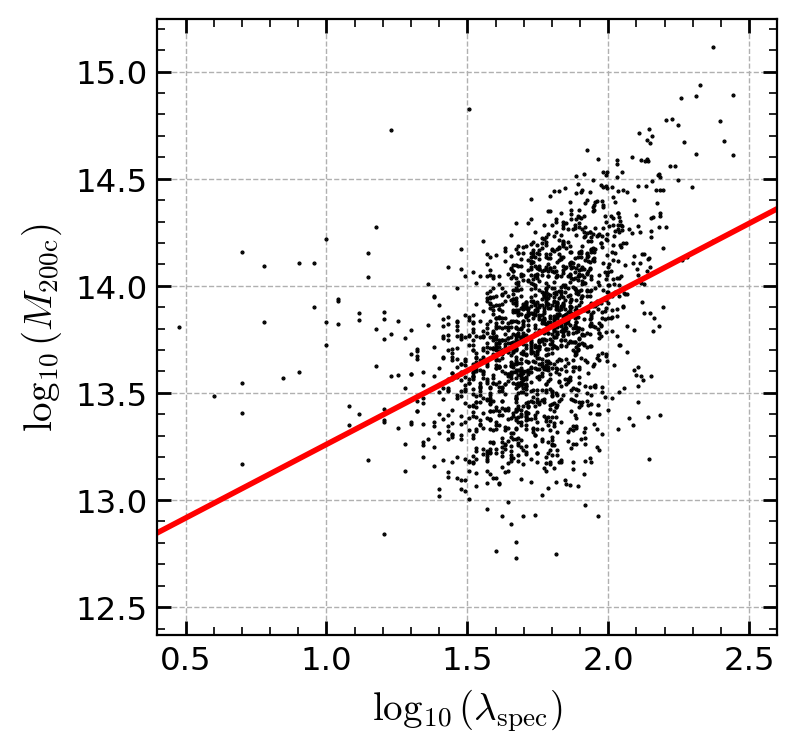

In [ ]:
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(feat_train, theta_train, '.k', label='Train', ms=1)
x_ = np.linspace(12.5, 15, 100)
ax.plot((x_-intercept)/coef, x_,  label='Fit', c='r')
# plt.plot(x_, x_, c='k', ls='--')
ax.set_xlim(0.4, 2.6)
ax.set(xlabel=r'$\log_{10}(\lambda_{\rm spec})$',
       ylabel=r'$\log_{10}(M_{\rm 200c})$')